# Análise do Dataset Scielo

## Imports

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import multiprocessing

from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from funcoes import limpa_html
from nlp_funcoes import token_lemma, add_bigram, create_dictionary, create_corpus, ModelLDA, calc_coherence

## Leitura do dataset

In [3]:
# muda o diretório atual para a pasta code onde temos o dataset salvo
os.chdir("../code")
os.getcwd()

'D:\\OneDrive\\monografia\\code'

In [4]:
df = pd.read_feather('scielo_dataset.feather')

In [5]:
df = df.query('ano > 2014')

## Limpeza do dataset

In [6]:
with multiprocessing.Pool() as pool:
    textos = list(tqdm(pool.imap(limpa_html, df['text_html']), total=len(df)))

  0%|          | 0/810 [00:00<?, ?it/s]

## Análise dos Dados

### Tokenize and Lemma

In [7]:
with multiprocessing.Pool() as pool:
    documentos = list(tqdm(pool.imap(token_lemma, textos), total=len(textos)))

  0%|          | 0/810 [00:00<?, ?it/s]

### Bigram, dicionário e corpus

In [8]:
add_bigram(documentos, min_count=5)
dicionario = create_dictionary(documentos, no_below=20, no_above=0.6)
corpus = create_corpus(dicionario, documentos)

### Modelo LDA

In [9]:
temp = dicionario[0]
id2word = dicionario.id2token

In [10]:
lda = ModelLDA(corpus, id2word)

### GridSearch no número de tópicos

In [11]:
n_topicos = list(range(6,21))
with multiprocessing.Pool(processes=8) as pool:
    modelos = list(tqdm(pool.imap(lda.run, n_topicos), total=len(n_topicos)))

  0%|          | 0/15 [00:00<?, ?it/s]

In [12]:
coerencias = {'u_mass': [],
              'c_v': [],
              'c_uci': [],
              'c_npmi': []}

for modelo in tqdm(modelos):
    for coe in tqdm(coerencias.keys(), leave=False):
        coerencias[coe].append(calc_coherence(modelo, documentos, dicionario, corpus, coe))

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

### Gráfico das coerências

In [13]:
def plot_coerencias(coerencias):
    fig, ax = plt.subplots(nrows=1, ncols=len(coerencias), figsize=(5*len(coerencias), 5))
    for i, k in enumerate(coerencias):
        y = coerencias[k]

        ax[i].set_title(k)
        ax[i].set_xlabel('Número de tópicos')

        ax[i].scatter(n_topicos, y, s=12, c='black')
        ax[i].plot(n_topicos, y, c='black')

    fig.tight_layout()    
    plt.show()

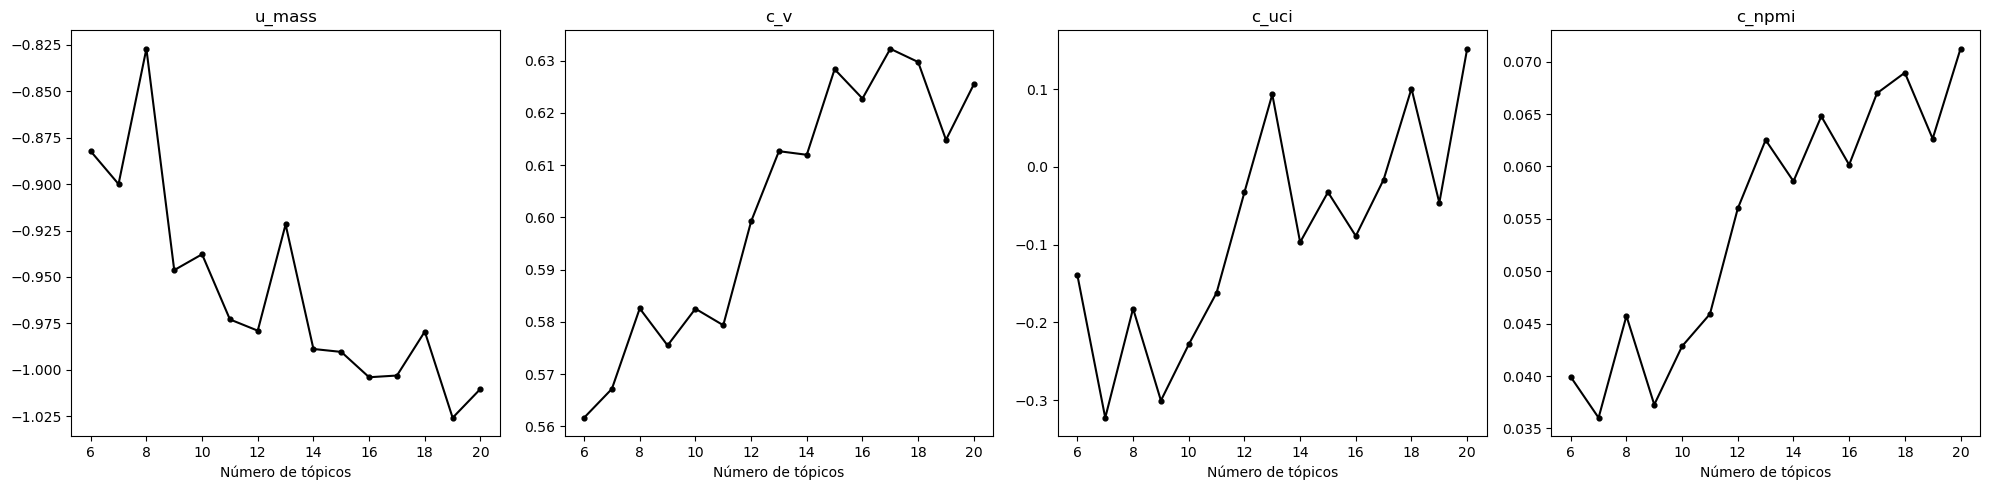

In [14]:
plot_coerencias(coerencias)

### Normalização das coerências 

In [15]:
norm_coerencias = {}
for k, v in coerencias.items():
    x = np.array(v)
    norm_coerencias[k] = (x - min(x)) / (max(x) - min(x))

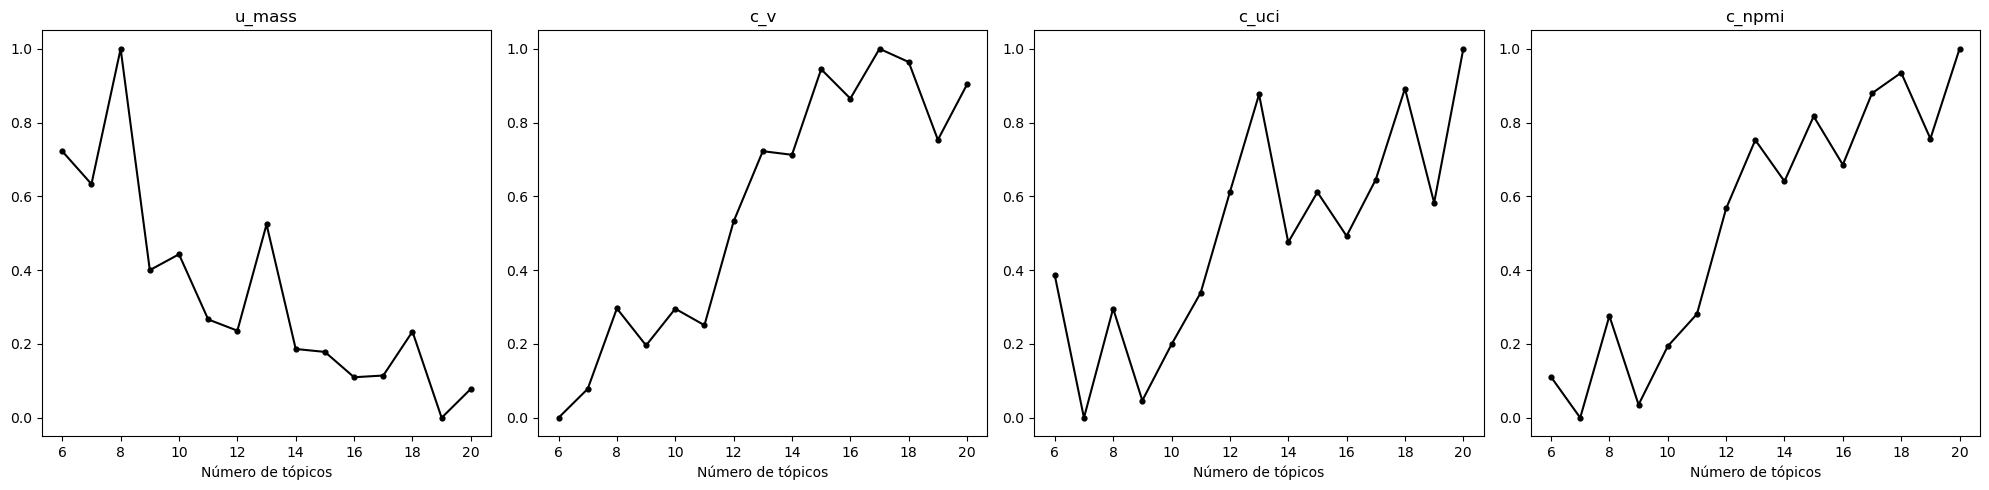

In [16]:
plot_coerencias(norm_coerencias)

In [17]:
medias = sum(norm_coerencias.values()) / 4
for i in medias.argsort()[::-1]:
    print(f'Número de tópicos: {str(n_topicos[i]).rjust(2, "0")} | {medias[i]:.3f}')

Número de tópicos: 18 | 0.756
Número de tópicos: 20 | 0.745
Número de tópicos: 13 | 0.719
Número de tópicos: 17 | 0.660
Número de tópicos: 15 | 0.638
Número de tópicos: 16 | 0.538
Número de tópicos: 19 | 0.523
Número de tópicos: 14 | 0.504
Número de tópicos: 12 | 0.487
Número de tópicos: 08 | 0.467
Número de tópicos: 06 | 0.305
Número de tópicos: 11 | 0.284
Número de tópicos: 10 | 0.283
Número de tópicos: 07 | 0.178
Número de tópicos: 09 | 0.170


## Número de tópicos = 11

In [21]:
model = modelos[13 - n_topicos[0]]

In [22]:
model.print_topics()

[(0,
  '0.016*"solução" + 0.010*"espaço" + 0.009*"partícula" + 0.009*"vetor" + 0.008*"operador" + 0.008*"transformação" + 0.007*"coordenada" + 0.007*"simetria" + 0.007*"derivada" + 0.006*"matriz"'),
 (1,
  '0.021*"sol" + 0.016*"terra" + 0.012*"planeta" + 0.011*"distância" + 0.011*"lua" + 0.008*"ângulo" + 0.008*"órbita" + 0.007*"centro" + 0.007*"arco" + 0.006*"kepler"'),
 (2,
  '0.018*"temperatura" + 0.010*"calor" + 0.009*"equilíbrio" + 0.008*"pressão" + 0.007*"escala" + 0.007*"gás" + 0.007*"fase" + 0.006*"comportamento" + 0.006*"universo" + 0.006*"parâmetro"'),
 (3,
  '0.045*"quântico" + 0.013*"probabilidade" + 0.010*"mecânico" + 0.009*"clássico" + 0.009*"informação" + 0.009*"partícula" + 0.008*"rede" + 0.007*"mecânico_quântico" + 0.007*"distribuição" + 0.006*"porta"'),
 (4,
  '0.026*"magnético" + 0.022*"elétrico" + 0.016*"partícula" + 0.016*"carga" + 0.010*"potencial" + 0.009*"campo_magnético" + 0.009*"força" + 0.009*"interação" + 0.007*"átomo" + 0.007*"campo_elétrico"'),
 (5,
  '0.02